# Tech Challenge 02 - Prevendo dados da Bolsa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

* o modelo com o storytelling, desde a captura do dado até a entrega do modelo
* justificar a técnica utilizada
* atingir uma acuracidade adequada (acima de 70%)

### 01 - Importando bibliotecas

In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf

#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          
from statsmodels.tsa.stattools import acf, pacf       
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA           
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Encontrando os Picos de Sazonalidade
from scipy.signal import find_peaks

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics



#### 01.1 - Fazendo Upload dos dados

In [2]:
import yfinance as yf

# Especifique o símbolo da IBOVESPA (^BVSP) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2021-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,119024.0,120354.0,118062.0,118558.0,118558.0,8741400
1,2021-01-05,118835.0,119790.0,116756.0,119223.0,119223.0,9257100
2,2021-01-06,119377.0,120924.0,118917.0,119851.0,119851.0,11638200
3,2021-01-07,119103.0,121983.0,119101.0,121956.0,121956.0,11774800
4,2021-01-08,122387.0,125324.0,122386.0,125077.0,125077.0,11085800


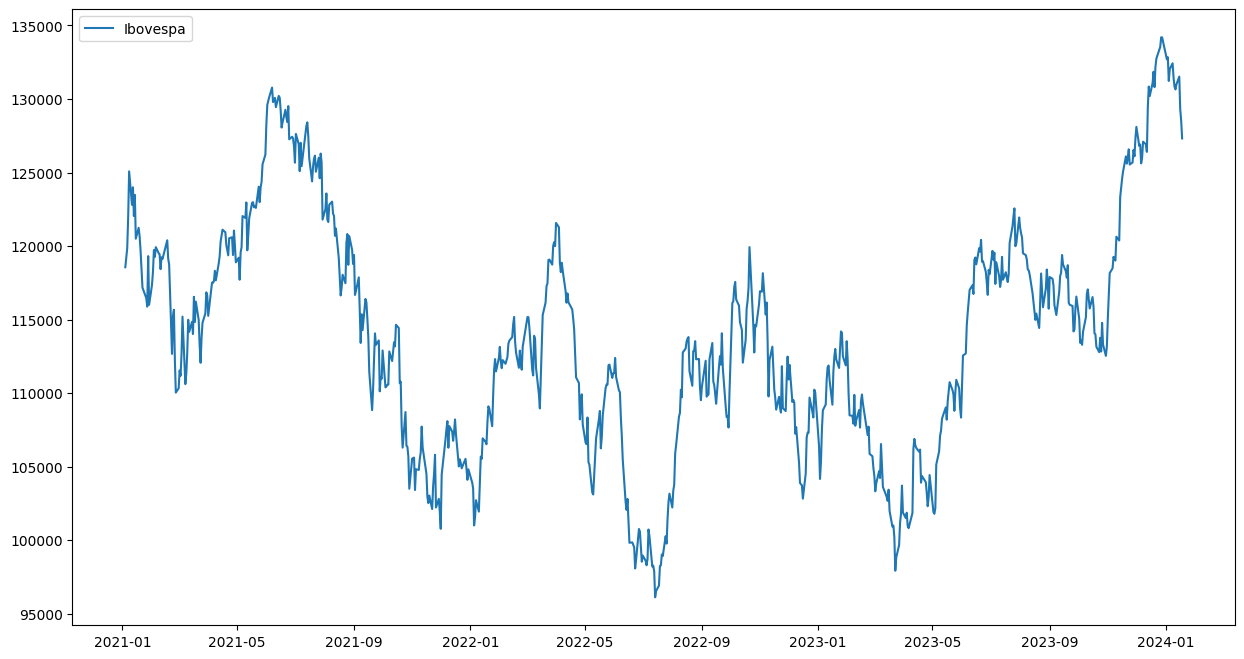

In [4]:
plt.figure(figsize = (15,8))
plt.plot(df['Date'], df['Close'], label='Ibovespa')

plt.legend(loc='best')
plt.show()

#### 01.2 - Analisando a Decomposição da Série Temporal

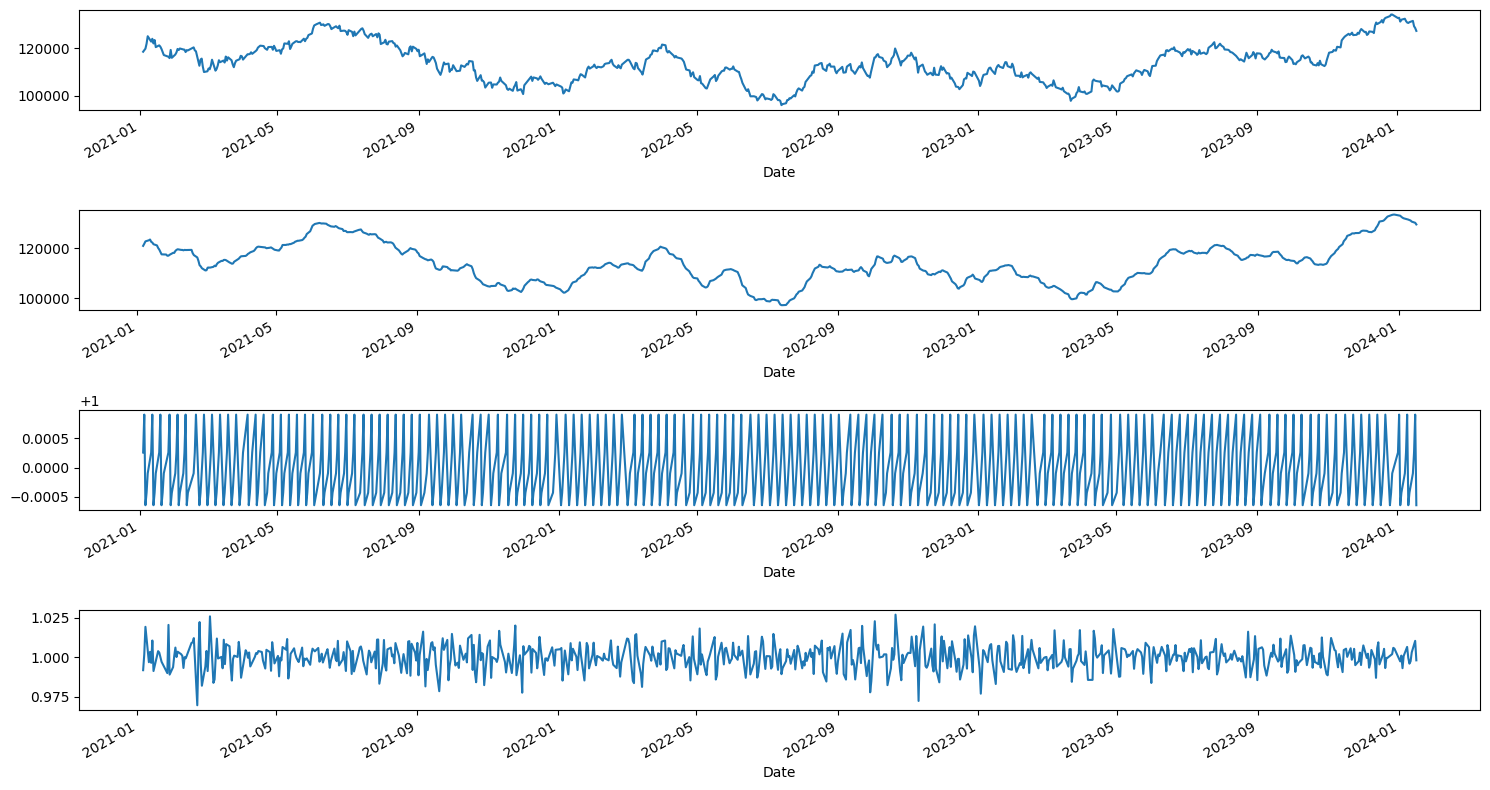

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) 
df_limpo = df_limpo.set_index('Date')                                      

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) 
seasonplot.trend.plot(ax=ax2)    
seasonplot.seasonal.plot(ax=ax3) 
seasonplot.resid.plot(ax=ax4)    
plt.tight_layout()

### 02 - Testando Modelos

#### 02.1 - Trabalhando com Estacionáridade (M.M.A. e ARIMA)

#### 02.1.1 - Média Móvel com janela de prévisão de 10 dias e 20 dias

In [6]:
df = pd.DataFrame(df[['Close', 'Date']])
df.set_index('Date', inplace=True)
df['MA_window_10'] = df['Close'].rolling(10).mean().shift()
df['MA_window_20'] = df['Close'].rolling(20).mean().shift()

In [7]:
df.head(21)

,Close,MA_window_10,MA_window_20
Date,,,
2021-01-04,118558.0,NaN,NaN
2021-01-05,119223.0,NaN,NaN
2021-01-06,119851.0,NaN,NaN
2021-01-07,121956.0,NaN,NaN
2021-01-08,125077.0,NaN,NaN
2021-01-11,122807.0,NaN,NaN
2021-01-12,123998.0,NaN,NaN
2021-01-13,122040.0,NaN,NaN
2021-01-14,123481.0,NaN,NaN


##### Visualizando o resultado:

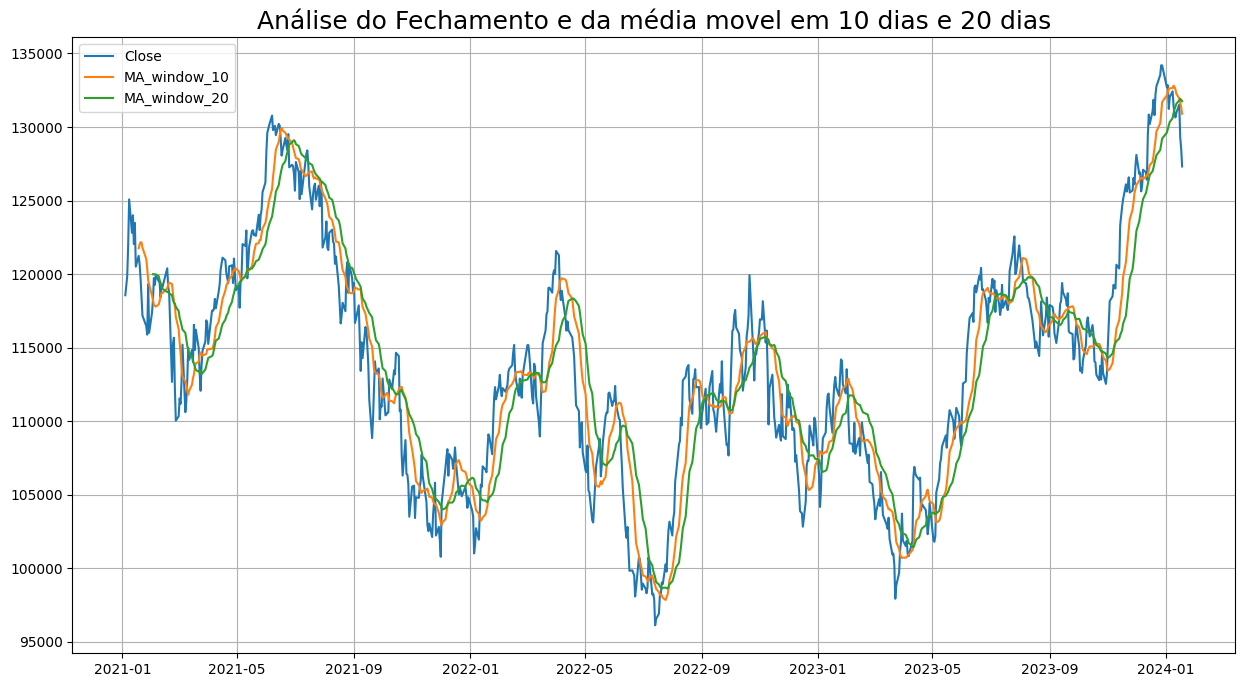

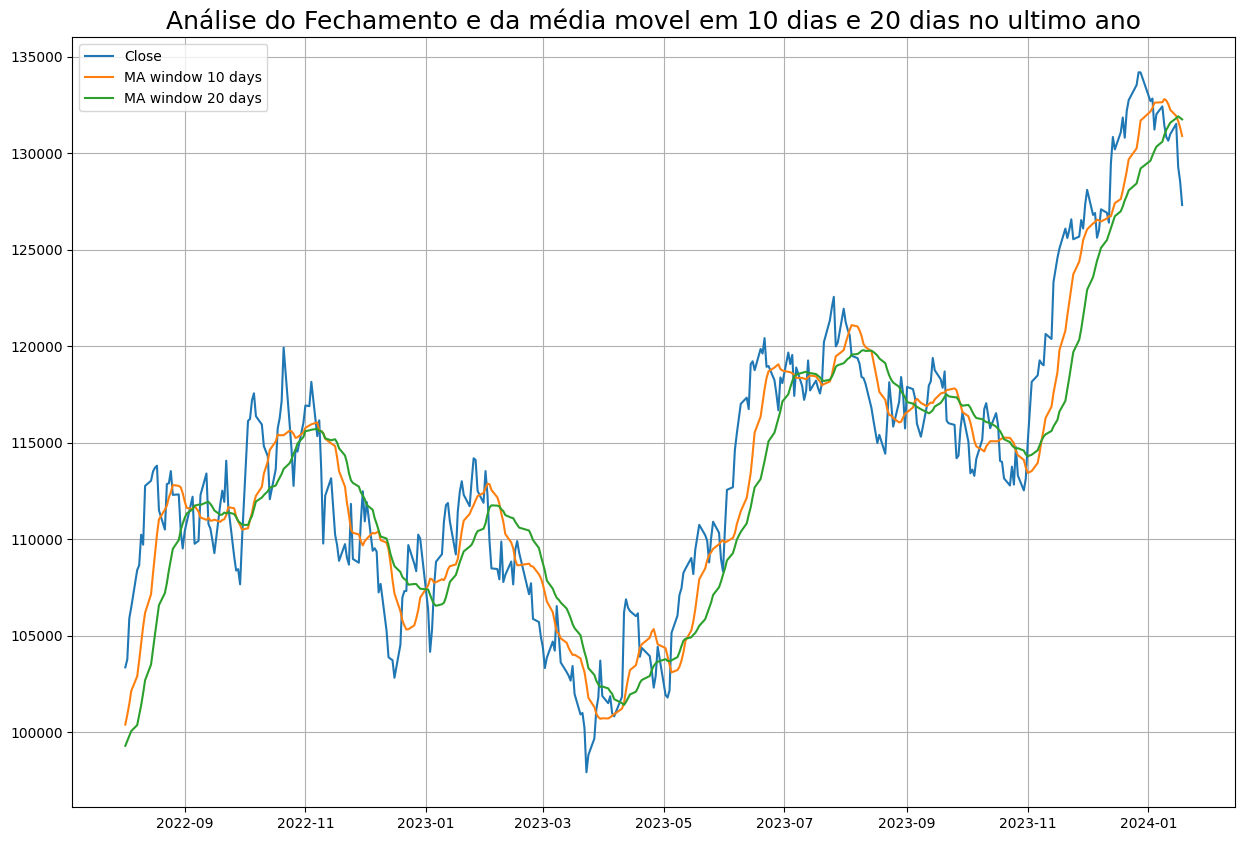

In [8]:
# Analisando todo o período com a média móvel
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df['Close'], label = 'Close')
plt.plot(df['MA_window_10'], label = 'MA_window_10')
plt.plot(df['MA_window_20'], label = 'MA_window_20')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias',
          loc='center',  fontsize=18)
plt.show()

# Destacando o período aos ultimo ano

limit = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias no ultimo ano',
          loc='center',  fontsize=18)
plt.show()




##### Prevendo "N" dias com base na MMA (Média Móvel Aritmética)

Nessa parte trabalharemos com a média movél de 10 dias e 20 dias, criando uma janela de tempo para ambas de modo a observar seu movimento de predição.

In [9]:
df['MA_window_10_forward_10'] = np.NaN
df['MA_window_20_forward_20'] = np.NaN

#Função para criar a jalena de período
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [10]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


In [11]:
window_size = 20
forward_days = 20

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_20_forward_20'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_20_forward_20')] = mean


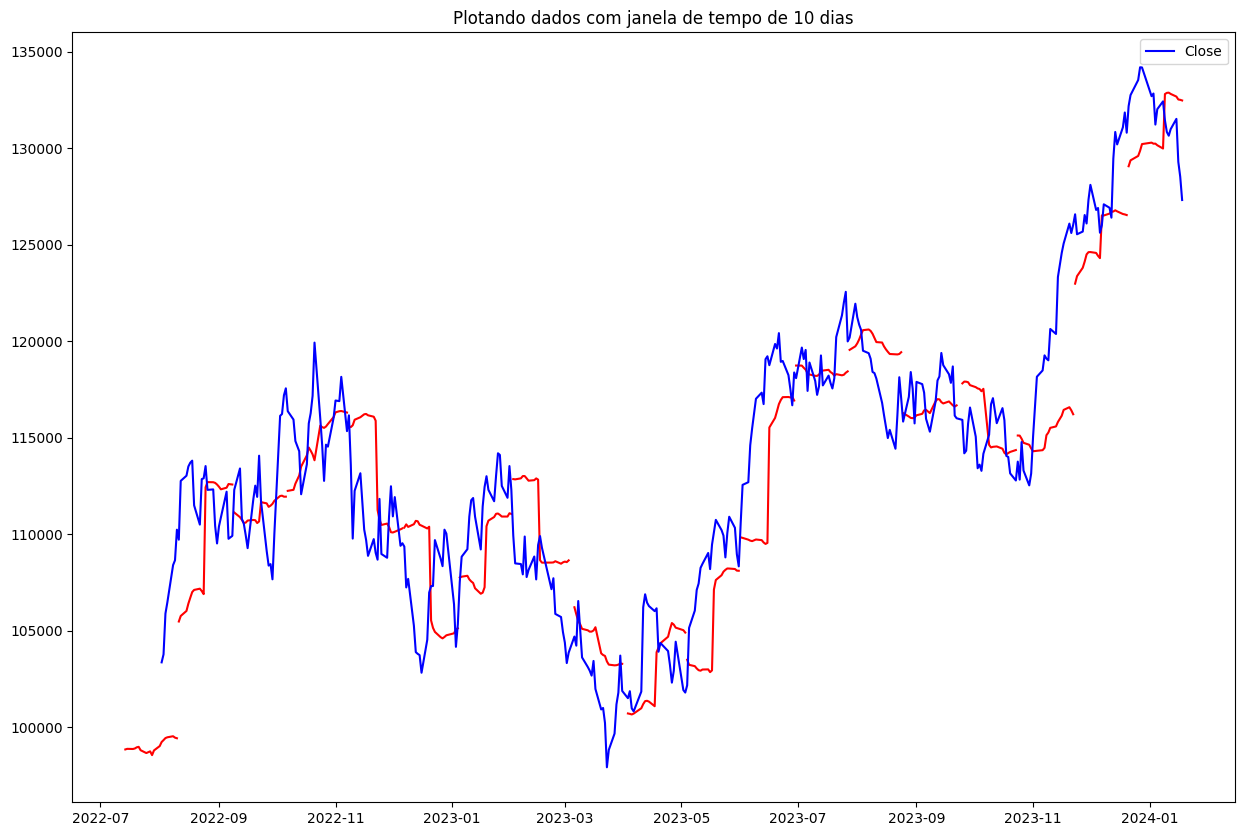

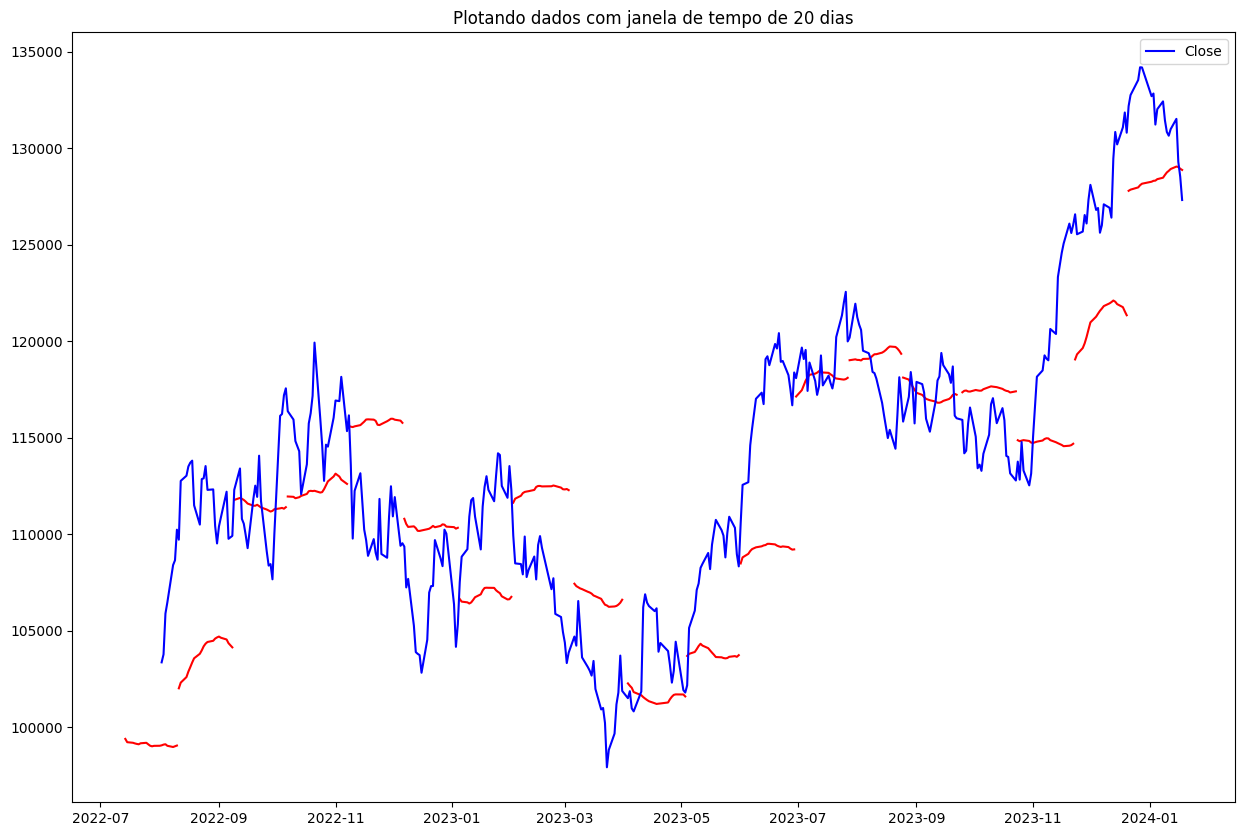

In [12]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc='best')
plt.show()

#Plotando dados com janela de 20 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 20 dias')
plt.legend(loc='best')
plt.show()

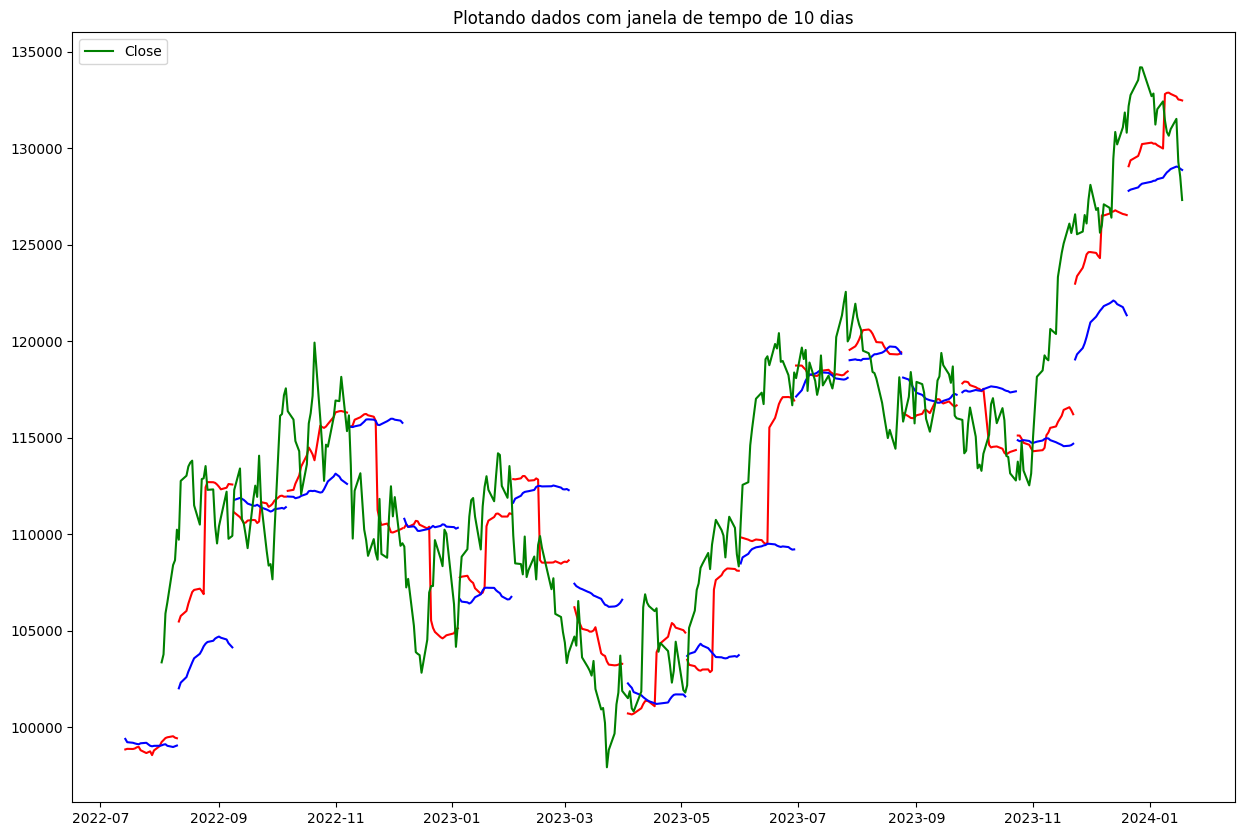

In [13]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='b')


plt.plot(df['Close'][-limit:], color='g', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc=2)
plt.show()

#### 02.1.2 - Módelo ARIMA

#### 02.1.2.1 - ARIMA

##### Teste de Dickey-Fuller - Verificando a Estacionariedade da Série

In [14]:
# Teste de estacionariedade (ADF Test)

adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1].astype(int)}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificação se a série é estacionária
alpha = 0.05  # Limiar de significância
if adf_result[1] < alpha:
    print('A série é estacionária. Hipótese nula rejeitada.')
else:
    print('A série não é estacionária. Falha em rejeitar a hipótese nula.')

ADF Statistic: -2.1644185710275226
p-value: 0
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.1644185710275226
Valor-p: 0.21941189199055994
Valores Críticos:
   1%: -3.4390179167598367
   5%: -2.8653655786032237
   10%: -2.5688071343462777
A série não é estacionária. Falha em rejeitar a hipótese nula.


##### Teste de Dickey-Fuller - Transformando a Série em estacionária

In [15]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    adf_result = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    alpha = 0.05  # Limiar de significância
    if adf_result[1] < alpha:
        print('A série é estacionária. Hipótese nula rejeitada.')
    else:
        print('A série não é estacionária. Falha em rejeitar a hipótese nula.')
        print(f'Valor-p: {adf_result[1]}')
        print(f'Limiar de Significância (alpha): {alpha}')


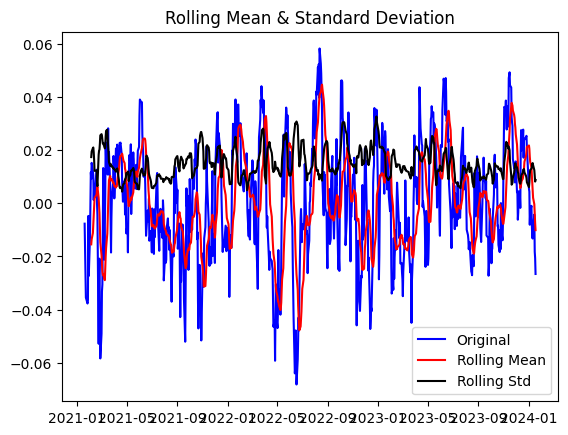

Results of Dickey Fuller Test:
Test Statistic                -7.445476e+00
p-value                        5.853882e-11
#Lags Used                     0.000000e+00
Number of Observations Used    7.460000e+02
Critical Value (1%)           -3.439146e+00
Critical Value (5%)           -2.865422e+00
Critical Value (10%)          -2.568837e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [16]:
# Log pela média móvel
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma

# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

# Subtraindo os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

test_stationarity(datasetLogScaleMinusMovingAverage)

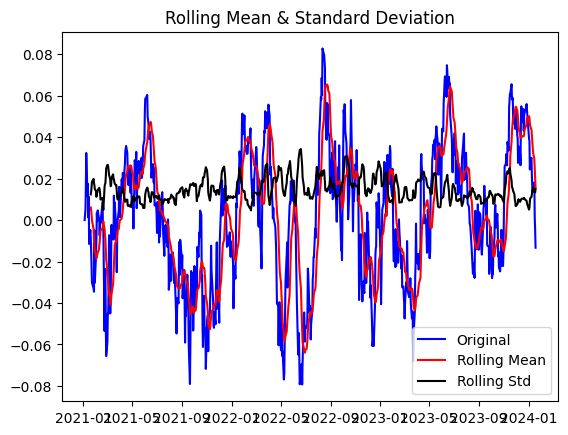

Results of Dickey Fuller Test:
Test Statistic                  -5.034257
p-value                          0.000019
#Lags Used                       0.000000
Number of Observations Used    757.000000
Critical Value (1%)             -3.439018
Critical Value (5%)             -2.865366
Critical Value (10%)            -2.568807
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [17]:
# Decaimento Exponencial
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()

# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)


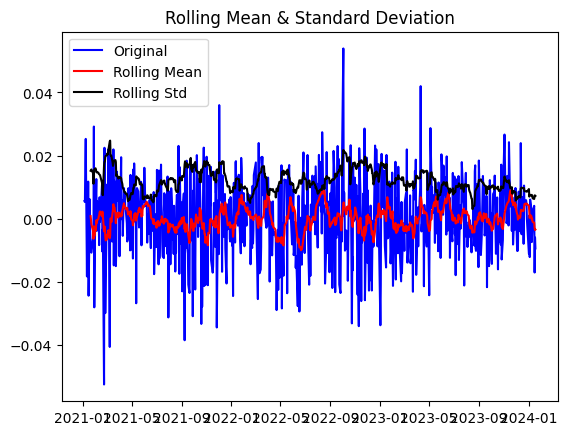

Results of Dickey Fuller Test:
Test Statistic                 -28.197911
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    756.000000
Critical Value (1%)             -3.439029
Critical Value (5%)             -2.865371
Critical Value (10%)            -2.568810
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [18]:
# Diferenciação

datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


##### Teste de correlação parcial

O ACF toca zero pela primeira vez no atraso 1.
O PACF toca zero pela primeira vez no atraso 1.


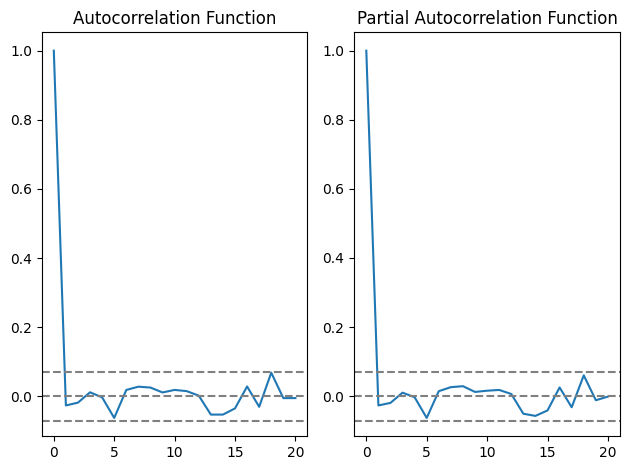

In [19]:
# Calcular ACF e PACF
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Encontrar o primeiro ponto em que ACF toca zero
zero_crossing_acf = next(i for i, value in enumerate(lag_acf) if value <= 0)

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

# Encontrar o primeiro ponto em que PACF toca zero
zero_crossing_pacf = next(i for i, value in enumerate(lag_pacf) if value <= 0)

# Imprimir os resultados
print(f'O ACF toca zero pela primeira vez no atraso {zero_crossing_acf}.')
print(f'O PACF toca zero pela primeira vez no atraso {zero_crossing_pacf}.')

plt.tight_layout()
plt.show()

##### Plotando o Arima e Avaliando o MAPE (Mean Absolute Percentage Error)

Plotting AR model
RSS: 0.1181
MAPE: 1169.31%


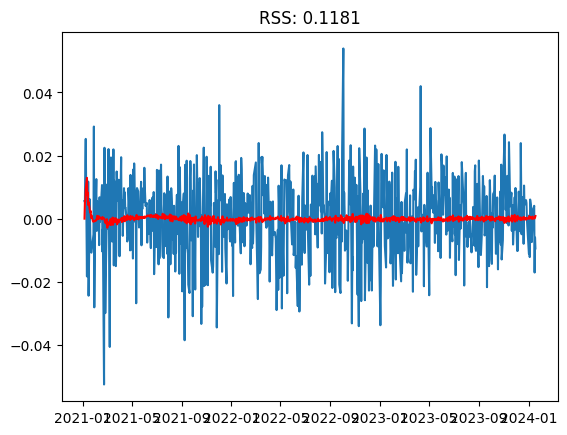

In [20]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(3,1,3))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')
print('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))


# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

#### 02.2 - Trabalhando com Previsões (Prophet e LSTM)

#### 02.2.1 - PROPHET

In [21]:
# Importando os dados do IBOVESPA para o modelo

symbol = '^BVSP'
start_date = '2021-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds', 'y']] = df[['Date', 'Close']]
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Close,ds,y
0,2021-01-04,118558.0,2021-01-04,118558.0
1,2021-01-05,119223.0,2021-01-05,119223.0
2,2021-01-06,119851.0,2021-01-06,119851.0
3,2021-01-07,121956.0,2021-01-07,121956.0
4,2021-01-08,125077.0,2021-01-08,125077.0


#### 02.2.1.1 - Separando os dados em treino e teste

In [22]:
train_data = df.sample(frac=0.75, random_state=23)
test_data = df.drop(train_data.index)
print(f'Volume de dados de treino: {train_data.shape}')
print(f'Volume de dados de teste: {test_data.shape}')

Volume de dados de treino: (568, 4)
Volume de dados de teste: (190, 4)


In [25]:
pptModel = Prophet(daily_seasonality=True)
pptModel.fit(train_data)
dataFramefuture = pptModel.make_future_dataframe(periods=3, freq='M')
previsao = pptModel.predict(dataFramefuture)
previsao.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-05,118008.595695,112987.722358,119919.104431,118008.595695,118008.595695,-1605.547275,-1605.547275,-1605.547275,1186.222237,...,-314.910436,-314.910436,-314.910436,-2476.859076,-2476.859076,-2476.859076,0.0,0.0,0.0,116403.048420
1,2021-01-06,117983.303276,113388.069102,120254.234113,117983.303276,117983.303276,-1073.021705,-1073.021705,-1073.021705,1186.222237,...,189.505052,189.505052,189.505052,-2448.748994,-2448.748994,-2448.748994,0.0,0.0,0.0,116910.281571
2,2021-01-07,117958.010857,113633.706410,120164.005252,117958.010857,117958.010857,-1124.858616,-1124.858616,-1124.858616,1186.222237,...,103.385249,103.385249,103.385249,-2414.466101,-2414.466101,-2414.466101,0.0,0.0,0.0,116833.152241
3,2021-01-11,117856.841180,113340.933735,120108.499166,117856.841180,117856.841180,-936.498697,-936.498697,-936.498697,1186.222237,...,62.289626,62.289626,62.289626,-2185.010560,-2185.010560,-2185.010560,0.0,0.0,0.0,116920.342483
4,2021-01-14,117780.963922,113993.853576,120385.260871,117780.963922,117780.963922,-597.164646,-597.164646,-597.164646,1186.222237,...,103.385249,103.385249,103.385249,-1886.772132,-1886.772132,-1886.772132,0.0,0.0,0.0,117183.799276


A Biblioteca de retorno da previsão é:

ds (Carimbo de data): Esta coluna representa as datas para as quais as previsões estão sendo feitas.

trend (Tendência): É a estimativa da tendência geral nos dados.

yhat_lower e yhat_upper: Esses são os limites inferior e superior dos valores previstos (yhat). O modelo fornece uma estimativa intervalar para as previsões.

trend_lower e trend_upper: Esses são os limites inferior e superior para a tendência geral.

additive_terms, additive_terms_lower, additive_terms_upper: Representam componentes adicionais adicionados à tendência, incluindo sazonalidades diárias, semanais, anuais e outras especificadas.

daily (Diário): O componente de sazonalidade diária.

weekly (Semanal): O componente de sazonalidade semanal.

yearly (Anual): O componente de sazonalidade anual.

multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper: Representam componentes multiplicativos, mas, no seu caso, parecem ser todos zeros, indicando que não há termos multiplicativos.

yhat: Este é o valor previsto (previsão) para cada data.

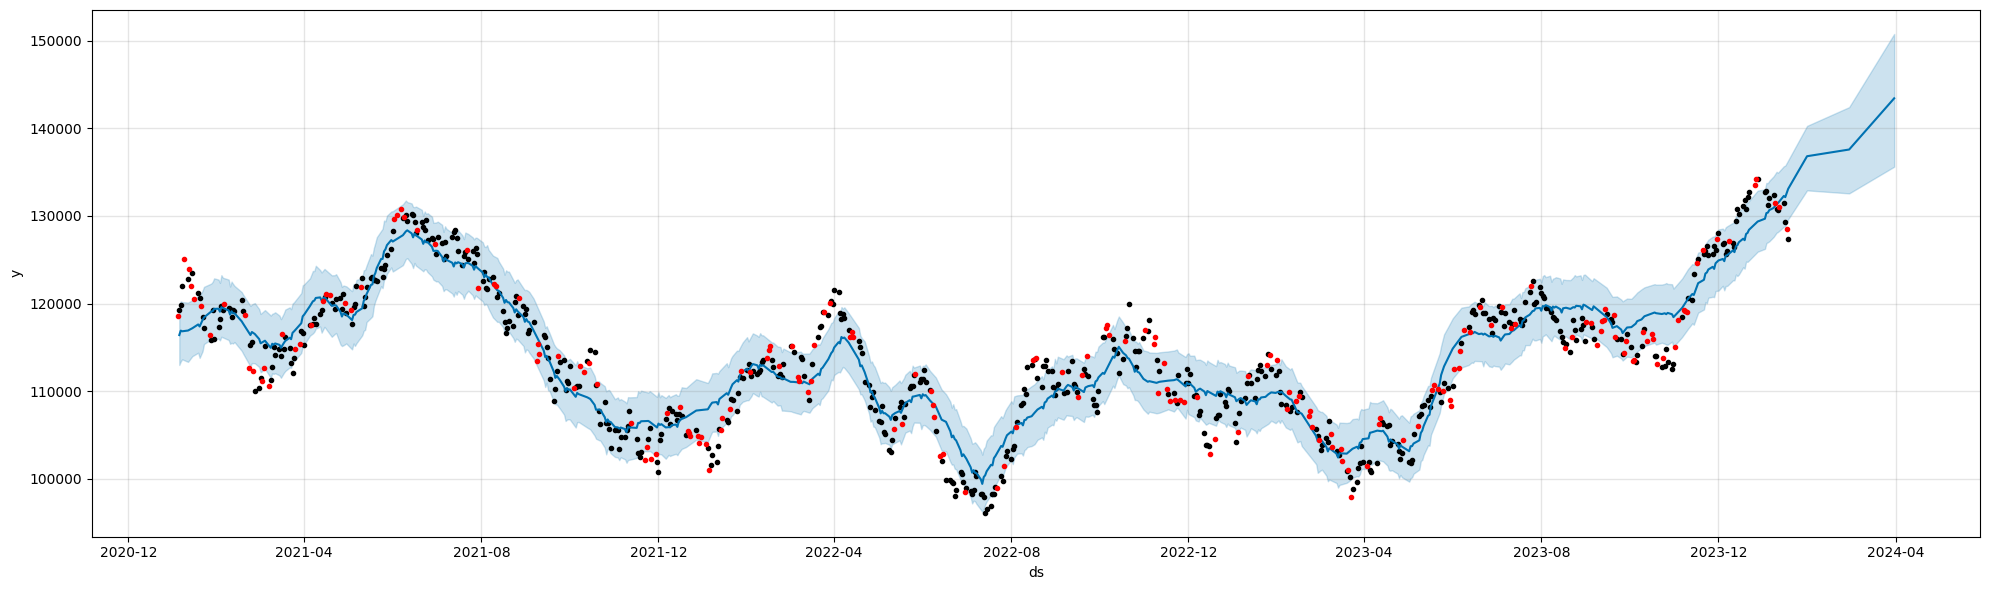

In [26]:
pptModel.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

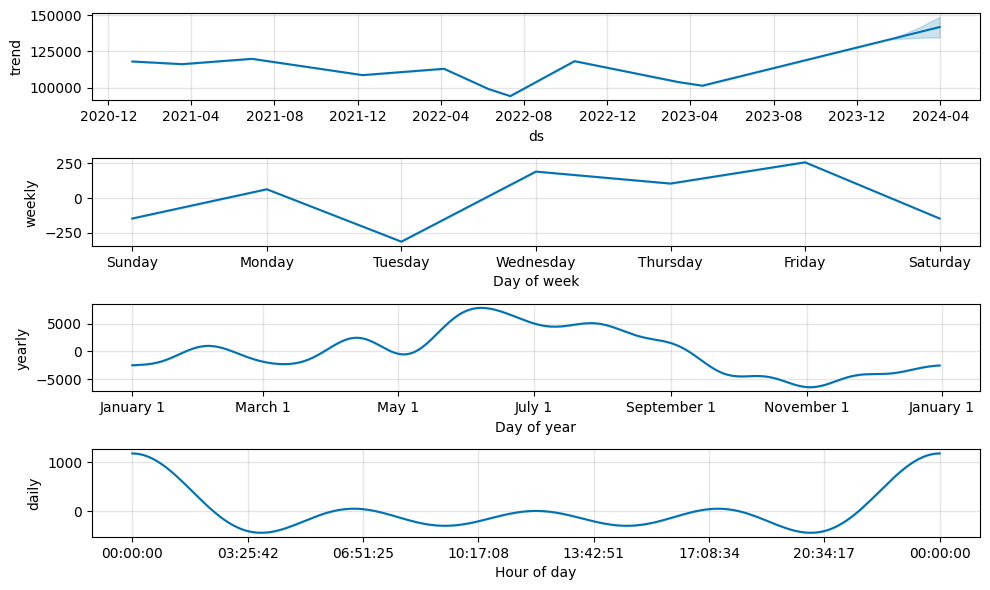

In [27]:
pptModel.plot_components(previsao, figsize=(10,6));

#### 02.2.1.2 - PROPHET - Avaliando o modelo

Avaliando os resultados do Prophet

In [28]:
pptModel = Prophet(daily_seasonality=True)
pptModel.fit(train_data)
dataFramefuture = pptModel.make_future_dataframe(periods=3, freq='M')
previsao = pptModel.predict(dataFramefuture)

valores_reais_cols = ['ds', 'y']
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
previsao = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o MSE e RMSE
mse = mean_squared_error(previsao['y'], previsao['yhat'])
rmse = np.sqrt(mse)

# Calcular o MAE
mae = mean_absolute_error(previsao['y'], previsao['yhat'])

# Calcular o MAPE
mape = np.mean(np.abs((previsao['y'] - previsao['yhat']) / previsao['y'])) * 100

# Calcular o MdAPE
mdape = np.median(np.abs((previsao['y'] - previsao['yhat']) / previsao['y'])) * 100

# SMAPE precisa de um tratamento especial se houver valores zero em 'y'
smape = 2 * np.mean(np.abs(previsao['y'] - previsao['yhat']) / (np.abs(previsao['y']) + np.abs(previsao['yhat']))) * 100

# Calcular a cobertura (coverage)
coverage = np.mean((previsao['y'] >= previsao['yhat_lower']) & (previsao['y'] <= previsao['yhat_upper'])) * 100

# Imprimir os previsao
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'MdAPE: {mdape}')
print(f'SMAPE: {smape}')
print(f'Coverage: {coverage}')

MSE: 7041798.187902869
RMSE: 2653.6386694316293
MAE: 2117.5857865067433
MAPE: 1.880138088451681
MdAPE: 1.5358507902312568
SMAPE: 1.8764353631505013
Coverage: 79.92957746478874


Utilizando o Cross_Validation no comparativo

In [29]:
df_cv = cross_validation(pptModel, initial='90 days', period='3 days', horizon = '365 days')

# Calcular o MSE e RMSE
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

# Calcular o MAE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])

# Calcular o MAPE
mape = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

# Calcular o MdAPE
mdape = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

# SMAPE precisa de um tratamento especial se houver valores zero em 'y'
smape = 2 * np.mean(np.abs(df_cv['y'] - df_cv['yhat']) / (np.abs(df_cv['y']) + np.abs(df_cv['yhat']))) * 100

# Calcular a cobertura (coverage)
coverage = np.mean((df_cv['y'] >= df_cv['yhat_lower']) & (df_cv['y'] <= df_cv['yhat_upper'])) * 100

# Imprimir os resultados
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'MdAPE: {mdape}')
print(f'SMAPE: {smape}')
print(f'Coverage: {coverage}')



100%|██████████| 218/218 [01:11<00:00,  3.07it/s]

MSE: 51880346068.78159
RMSE: 227772.57532192412
MAE: 83451.47117282708
MAPE: 73.52324616962866
MdAPE: 26.214905155005596
SMAPE: 45.258028134083716
Coverage: 16.01162705488654


**Sem Cross Validation:**
- **MSE (Erro Quadrático Médio):** 31602033.60
- **RMSE (Raiz do Erro Quadrático Médio):** 5621.57
- **MAE (Erro Absoluto Médio):** 3768.76
- **MAPE (Erro Percentual Absoluto Médio):** 7.02%
- **MdAPE (Erro Percentual Absoluto Mediano):** 5.42%
- **SMAPE (Erro Percentual Absoluto Médio Simétrico):** 6.86%
- **Coverage (Cobertura):** 85.37%

**Com Cross Validation:**
- **MSE (Erro Quadrático Médio):** 176245905.23
- **RMSE (Raiz do Erro Quadrático Médio):** 13275.76
- **MAE (Erro Absoluto Médio):** 9909.55
- **MAPE (Erro Percentual Absoluto Médio):** 17.75%
- **MdAPE (Erro Percentual Absoluto Mediano):** 13.01%
- **SMAPE (Erro Percentual Absoluto Médio Simétrico):** 17.73%
- **Coverage (Cobertura):** 29.45%

**Análise:**
- **Sem Cross Validation:** O modelo parece ter um desempenho relativamente bom com métricas como MSE, RMSE e MAE. A cobertura (Coverage) de 85.37% sugere que os intervalos de previsão capturaram adequadamente os valores reais na maioria das previsões.
  
- **Com Cross Validation:** As métricas indicam um aumento significativo nos erros, com RMSE e MAPE notavelmente mais altos. A cobertura (Coverage) de 29.45% sugere que os intervalos de previsão têm uma capacidade limitada de capturar os valores reais, indicando uma possível subestimação da incerteza.

**Considerações:**
- O aumento nas métricas com validação cruzada pode indicar que o modelo pode estar superajustado (overfitting) aos dados de treinamento, resultando em uma capacidade limitada de generalização para novos dados.
  


#### 02.2.2 - LSTM

In [32]:
# Importando os dados do IBOVESPA para o modelo

symbol = '^BVSP'
start_date = '2021-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

# Normalizando os Dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

[*********************100%%**********************]  1 of 1 completed


#### 02.2.2.1 - Separando os dados em treino e teste

In [33]:
split_percent = 0.75
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

568
190


In [34]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [35]:
np.random.seed(23)

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
lstm_model.add(Dense(1)),

lstm_model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
lstm_model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1797 - mean_squared_error: 0.1799
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mean_squared_error: 0.0069
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

In [36]:
# Avaliando o modelo nos dados de teste
mse = lstm_model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

# 1. Fazer previsões usando o conjunto de teste
test_predictions = lstm_model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Erro Quadrático Médio 0.0031456255819648504
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 1.8210
RMSE: 0.05608587684938919


In [37]:
prediction = lstm_model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

  1/180 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### 02.2.2.2 - Validando a Série Temporal com Suavização

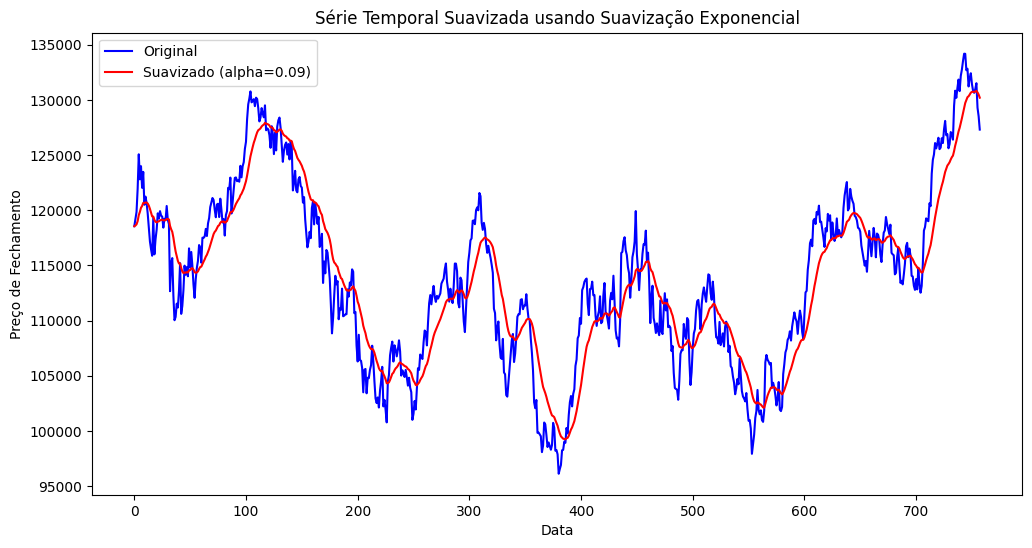

In [38]:
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime

# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [39]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
alpha = 0.05  # Limiar de significância
if adf_result[1] < alpha:
    print('A série é estacionária. Hipótese nula rejeitada.')
else:
    print('A série não é estacionária. Falha em rejeitar a hipótese nula.')
    print(f'Valor-p: {adf_result[1]}')
    print(f'Limiar de Significância (alpha): {alpha}')


ADF Statistic: -2.093938729193027
p-value: 0.24695884367569887
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.093938729193027
Valor-p: 0.24695884367569887
Valores Críticos:
   1%: -3.439029421541435
   5%: -2.8653706489231876
   10%: -2.568809835460933
A série não é estacionária. Falha em rejeitar a hipótese nula.
Valor-p: 0.24695884367569887
Limiar de Significância (alpha): 0.05


In [40]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2021-01-04,118558.000000
1,2021-01-05,118617.850000
2,2021-01-06,118728.833500
3,2021-01-07,119019.278485
4,2021-01-08,119564.473421


In [41]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

606
152


In [42]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1038 - mean_squared_error: 0.1051
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - mean_squared_error: 0.0157
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0054       
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0025
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013       
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011       
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0010       
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2235e-04 - mean_squared_error: 9.2058e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0012
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7171e-04 - mean_squared_error: 8.2962e-04
Epoch 11/100
31/3

In [43]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%"),

# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])
print("RMSE:", rmse_value)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.66%
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7713e-04 - mean_squared_error: 1.7713e-04
Erro Quadrático Médio: 0.00021399369870778173
RMSE: 0.01462852346300821


In [45]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### 02.2.2.3 - Realizando o Forecasting

In [48]:
close_data = close_data.reshape((-1))

# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [49]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

#### 02.2.2.4 - Organizando os Dados em um Dataframe

In [50]:
df_ltsm_suav = pd.DataFrame(df)
df_past = df_ltsm_suav[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan

# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')

results2023 =  results.loc['2023-01-01':]

plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast IBOVESPA'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()


In [51]:
# Importando os dados do IBOVESP para o modelo

symbol = '^BVSP'
start_date = '2019-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df_ltsm = yf.download(symbol, start=start_date, end=end_date)
df_ltsm = df_ltsm.reset_index('Date')
df_ltsm['Date'] = pd.to_datetime(df_ltsm['Date'])
df_ltsm.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df_past_ltsm = df_ltsm[['Date','Close']]

df_past_ltsm.rename(columns={'Close': 'Actual'}, inplace=True)
df_past_ltsm['Date'] = pd.to_datetime(df_past_ltsm['Date'])
df_past_ltsm['Forecast'] = np.nan
df_past_ltsm['Forecast'].iloc[-1] = df_past_ltsm['Actual'].iloc[-1]

df_future_ltsm = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future_ltsm['Date'] = forecast_dates
df_future_ltsm['Forecast'] = forecast.flatten()
# Concatenando os DataFrames usando concat
frames_ltsm = [df_past_ltsm, df_future_ltsm]
results_ltsm = pd.concat(frames_ltsm, ignore_index=True).set_index('Date')

results_ltsm2023 =  results_ltsm.loc['2023-01-01':]

plot_data = [
    go.Scatter(
        x=results_ltsm2023.index,
        y=results_ltsm2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results_ltsm2023.index,
        y=results_ltsm2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast IBOVESP'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

[*********************100%%**********************]  1 of 1 completed


### 03 - Conclusão

1. **Arima:**
   - RSS: 0.5549
   - MAPE: 1128.51%

2. **Prophet:**
   - MSE: 37019872.43
   - RMSE: 6084.40
   - MAE: 4578.85
   - MAPE: 5.56%
   - MdAPE: 4.27%
   - SMAPE: 5.45%
   - Coverage: 82.63%

   *Prophet Cross Validation:*
   - MSE: 424663591.91
   - RMSE: 20607.37
   - MAE: 16587.11
   - MAPE: 17.26%
   - MdAPE: 14.62%
   - SMAPE: 16.29%
   - Coverage: 29.72%

3. **LSTM:**
   - MAPE: 3.87%
   - RMSE: 0.0602

4. **LSTM Suavizado:**
   - Erro Quadrático Médio: 0.000141
   - RMSE: 0.0119

Observações:
- O modelo LSTM parece ter um desempenho bastante superior em termos de MAPE e RMSE em comparação com os outros modelos.
- O modelo Prophet, embora tenha apresentado um bom desempenho, possui uma maior variabilidade em seus indicadores em comparação com o LSTM.
- O modelo Arima teve um desempenho intermediário em termos de MAPE, mas seu RSS foi comparativamente menor.

Ao analisar os resultados dos modelos apresentados, podemos considerar os seguintes pontos:

1. **Arima:**
   - Apresentou um MAPE relativamente alto, indicando uma certa ineficiência na previsão.
   - O RSS também não é o mais baixo em comparação com outros modelos.

2. **Prophet:**
   - Apresentou indicadores variados, com MAPE e RMSE razoáveis, mas com grande variabilidade.
   - A cobertura (Coverage) nos resultados de validação cruzada é relativamente baixa.

3. **LSTM:**
   - Possui um MAPE bastante baixo e um RMSE pequeno, indicando um desempenho sólido.
   - É o modelo com os resultados mais promissores até agora.

4. **LSTM Suavizado:**
   - Apresentou um desempenho sólido, com erro quadrático médio e RMSE muito baixos.

Com base nessas análises, o modelo LSTM Suavizado parece ser uma escolha forte, pois conseguiu manter um desempenho notável em termos de MAPE e RMSE. No entanto, a escolha do melhor modelo pode depender de outros fatores, como a interpretação dos resultados, a complexidade do modelo, a facilidade de implementação e o tempo necessário para treinamento.